In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gffutils

PROJECT_PATH = Path("/work/rodrigues_2023/")

In [2]:
pilon_path = PROJECT_PATH / "data/variant_call/isolates/bowtie2_mr_cli_clc_rast_pilon"
gff_path = PROJECT_PATH / "data/genome_assembly/MR_Cli/02_rast_annotation_by_marinelle/all_ATEC_annotated_contigs.gff"
meta_path = PROJECT_PATH / "data/reference/isolates_curated_metadata.csv"
barcodes_path = PROJECT_PATH / "dump/20230503/dominant-barcodes/dominant_barcodes.csv"
mdk_path = PROJECT_PATH / "data/reference/20230503_MDK_table.csv"

In [3]:
meta = pd.read_csv(meta_path)
meta

,Colony Number,Identification,Sample ID,Mouse ID,Tissue,Media,Treatment
0,1,C3L Co Mac 1,C3L_CO_MAC1_S12,C3L,CO,MAC,Treated
1,2,C4L I Mac1,C4L_I_MAC1_S287,C4L,I,MAC,Treated
2,3,C4L I Mac2,C4L_I_MAC2_S171,C4L,I,MAC,Treated
3,4,C3L Co TSA1,C3L_CO_TSA1_S7,C3L,CO,TSA,Treated
4,5,C3L Co TSA2,C3L_CO_TSA2_S172,C3L,CO,TSA,Treated
...,...,...,...,...,...,...,...
155,156,C1L Co 17-5,17_5_S157,C1L,Co,LB,Untreated
156,157,C1R I 18-1,18_1_S158,C1R,I,LB,Untreated
157,300,C4L_S178,C4L_S178,C4L,I,LB,Untreated
158,301,C4N_S75,C4N_S75,C4N,I,LB,Untreated


In [4]:
barcodes = pd.read_csv(barcodes_path)
barcode_names = {val:f'B:{key}' for key,val in dict(enumerate(barcodes['barcode'].unique())).items()}
barcodes['barcode_id'] = barcodes['barcode'].apply(lambda x: barcode_names[x])
barcodes

,Sample ID,barcode,Colony Number,Identification,Mouse ID,Tissue,Media,Mouse+Tissue,barcode_id
0,C3L_I_LB4_S201,AGAGTGACTGT,36,C3L I LB4,C3L,I,LB,C3L_I,B:0
1,C4L_I_TSA5_S218,AGAGTGACTGT,53,C4L I TSA5,C4L,I,TSA,C4L_I,B:0
2,C3L_I_LB1_S206,AATGTTACCGA,41,C3L I LB1,C3L,I,LB,C3L_I,B:1
3,1_1_S237,AGAGTGACTGT,72,C2R Co 1-1,C2R,Co,LB,C2R_Co,B:0
4,11_4_S126,AGAGTGACTGT,125,C1N C 11-4,C1N,C,LB,C1N_C,B:0
...,...,...,...,...,...,...,...,...,...
136,C4R_I_LB2-2_S236,AGAGTGACTGT,71,C4L I LB2,C4L,I,LB,C4L_I,B:0
137,17_2_S154,ACGGTTTCTAA,153,C1L Co 17-2,C1L,Co,LB,C1L_Co,B:2
138,13_2_S134,AGAGTGACTGT,133,C1R Co 13-2,C1R,Co,LB,C1R_Co,B:0
139,16_2_S149,AGAGTGACTGT,148,C1L I 16-2,C1L,I,LB,C1L_I,B:0


In [5]:
mdk = pd.read_csv(mdk_path)
mdk

,Colony Number,MDK95,MDK99,MDK99.99
0,1.0,3.451394,5.428978,11.087545
1,2.0,3.659711,5.545203,10.940264
2,3.0,3.598487,5.647825,11.511703
3,4.0,3.428827,5.216415,10.331337
4,5.0,2.529978,4.102725,8.602907
...,...,...,...,...
153,154.0,2.649405,4.034902,7.999296
154,155.0,3.130119,4.956430,10.182151
155,156.0,3.829016,5.642944,10.833231
156,157.0,3.284493,5.014844,9.965988


In [6]:
def create_gff_database(gff_file, db_file):
    # Create a database from the GFF file
    db = gffutils.create_db(str(gff_file), dbfn=db_file, force=True, keep_order=True,
                            merge_strategy="create_unique")

def fetch_features_within_coordinates(db_file, contig, start, end):
    features_within_coordinates = []

    db = gffutils.FeatureDB(db_file)
    for feature in db.region(seqid=contig, start=start, end=end):
        features_within_coordinates.append(feature)

    return features_within_coordinates

def extract_feature_attributes(feature):
    gene = feature.attributes.get('gene', [''])[0].strip()
    locustag = feature.attributes.get('locus_tag', [''])[0].strip()
    product = feature.attributes.get('product', [''])[0].strip()
    uniprotkb = 'NA'
    if 'inference' in feature.attributes:
        inf = ' '.join(feature.attributes.get('inference', ['']))
        m = re.search('UniProtKB:(.+):?', inf)
        if m:
            uniprotkb = m.group(1)
    return gene, product, uniprotkb, locustag
# Define the input GFF file, database file, and genomic coordinates
db_file = f"{str(gff_path)}.db"
# Create the GFF database
create_gff_database(gff_path, db_file)


In [7]:
def find_mut_type(r):
    ref = r['Original Sequence']
    alt = r['New Sequence']
    if ref=='.':
        return pd.Series(['INS', len(alt)])
    elif alt=='.':
        return pd.Series(['DEL', len(ref)])
    else:
        return pd.Series(['SNP', 1])

def find_overlapping_features(r):
    # create a single result string with the following format:
    # gene1:product1:uniprotkb1;gene2:product2:uniprotkb2;...
    fstr = set()
    fgenes = set()
    # parse coordinates
    contig = r.split(':')[0]
    coor = r.split(':')[1]
    if '-' in coor:
        coor_start = coor.split('-')[0]
        coor_end = coor.split('-')[1]
    else:
        coor_start = int(coor)
        coor_end = int(coor)+1
        
    features = fetch_features_within_coordinates(db_file, contig, coor_start, coor_end)
    for feature in features:
        gene, product, uniprot_id, locustag = extract_feature_attributes(feature)
        #fstr += f"{gene}:{product}:{uniprot_id};"
        if len(locustag)>0:
            fstr.add(locustag)
        if len(product)>0:
            fgenes.add(product)
    return ",".join(list(fstr)), ",".join(list(fgenes))

var={}
for file in pilon_path.glob("*.changes"):
    sample_id = str(file.name).split('.')[0]
    # Read Pilon changes file
    var[sample_id] = pd.read_csv(file, sep=' ', 
                                 names=['Original Scaffold Coordinate',
                                          'New Scaffold Coordinate',
                                          'Original Sequence',
                                          'New Sequence'])
    # Parse out coordinates
    var[sample_id]['Contig'] = var[sample_id]['Original Scaffold Coordinate'].apply(lambda x: x.split(':')[0])
    if '-' in var[sample_id]['Original Scaffold Coordinate']:
        var[sample_id]['Start'] = var[sample_id]['Original Scaffold Coordinate'].apply(lambda x: x.split(':')[1].split('-')[0])
        var[sample_id]['End'] = var[sample_id]['Original Scaffold Coordinate'].apply(lambda x: x.split(':')[1].split('-')[1])
    else:
        var[sample_id]['Start'] = var[sample_id]['Original Scaffold Coordinate'].apply(lambda x: x.split(':')[1])
    # Deduce mutation type
    var[sample_id][['Mutation Type','Mutation Length']] = var[sample_id][['Original Sequence', 'New Sequence']].apply(find_mut_type, axis=1)
    # Find overlapping features from gff
    var[sample_id]['Overlapping Features'], var[sample_id]['Overlapping Genes'] = zip(*var[sample_id]['Original Scaffold Coordinate'].apply(find_overlapping_features))
    # Create a sample ID column
    var[sample_id]['Sample ID'] = sample_id
    # Carry metadata over here
    # var[sample_id] = pd.merge(left=var[sample_id], right=meta, on='Sample ID', how='inner')
    # var[sample_id]['Mouse+Tissue'] = var[sample_id]['Mouse ID'] + '_' + var[sample_id]['Tissue']
    

In [8]:
allvar = pd.concat(var.values()).reset_index()
one = pd.merge(left=allvar, right=meta, on='Sample ID', how='outer')
one = pd.merge(left=one, right=barcodes[['Sample ID', 'barcode', 'barcode_id']], on='Sample ID', how='outer')
one = pd.merge(left=one, right=mdk, on='Colony Number', how='outer')
one.to_csv(PROJECT_PATH / 'dump/20230503/figures/isolate_mutations_barcodes_mdk_meta_pilon.csv', index=False)
one

,index,Original Scaffold Coordinate,New Scaffold Coordinate,Original Sequence,New Sequence,Contig,Start,Mutation Type,Mutation Length,Overlapping Features,...,Identification,Mouse ID,Tissue,Media,Treatment,barcode,barcode_id,MDK95,MDK99,MDK99.99
0,0.0,MR_Cli1_contig_4:373325-373446,MR_Cli1_contig_4_pilon:373325-373454,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,GATCGAACCGCTGACCTCTTGCATGCCATGCAAGCGCTCTCCCAGC...,MR_Cli1_contig_4,373325-373446,SNP,1.0,SEED:fig|6666666.487694.peg.3475,...,C3N Co TSA2,C3N,CO,TSA,Treated,AGAGTGACTGT,B:0,2.824732,4.290960,8.486357
1,1.0,MR_Cli1_contig_4:510794-510940,MR_Cli1_contig_4_pilon:510802-510948,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,CATTACGCGTCGCATCAGGCAACGGCTGTNNNNNNNNNNNNNNNNN...,MR_Cli1_contig_4,510794-510940,SNP,1.0,,...,C3N Co TSA2,C3N,CO,TSA,Treated,AGAGTGACTGT,B:0,2.824732,4.290960,8.486357
2,2.0,MR_Cli1_contig_5:204099,MR_Cli1_contig_5_pilon:204099,C,G,MR_Cli1_contig_5,204099,SNP,1.0,,...,C3N Co TSA2,C3N,CO,TSA,Treated,AGAGTGACTGT,B:0,2.824732,4.290960,8.486357
3,3.0,MR_Cli1_contig_5:204104,MR_Cli1_contig_5_pilon:204104,A,T,MR_Cli1_contig_5,204104,SNP,1.0,,...,C3N Co TSA2,C3N,CO,TSA,Treated,AGAGTGACTGT,B:0,2.824732,4.290960,8.486357
4,4.0,MR_Cli1_contig_9:1472-1490,MR_Cli1_contig_9_pilon:1472-1489,TGGTGTTCCCGCCGGTGCT,GGGGATTCCCGCCGGCAC,MR_Cli1_contig_9,1472-1490,SNP,1.0,SEED:fig|6666666.487694.peg.4662,...,C3N Co TSA2,C3N,CO,TSA,Treated,AGAGTGACTGT,B:0,2.824732,4.290960,8.486357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5729,32.0,MR_Cli1_contig_65:5474-5662,MR_Cli1_contig_65_pilon:5474-5662,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,TCACTGCATACCGGTCCGACCCCGTACAGCTTACGCAGCTTATCCA...,MR_Cli1_contig_65,5474-5662,SNP,1.0,,...,C2RL C 8-3,C2RL,C,LB,Untreated,AGAGTGACTGT,B:0,3.504420,5.318526,10.509324
5730,33.0,MR_Cli1_contig_65:6317,MR_Cli1_contig_65_pilon:6317,C,T,MR_Cli1_contig_65,6317,SNP,1.0,,...,C2RL C 8-3,C2RL,C,LB,Untreated,AGAGTGACTGT,B:0,3.504420,5.318526,10.509324
5731,34.0,MR_Cli1_contig_65:6319,MR_Cli1_contig_65_pilon:6319,T,C,MR_Cli1_contig_65,6319,SNP,1.0,,...,C2RL C 8-3,C2RL,C,LB,Untreated,AGAGTGACTGT,B:0,3.504420,5.318526,10.509324
5732,35.0,MR_Cli1_contig_70:755-867,MR_Cli1_contig_70_pilon:755-893,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,GGGGCATTGGGAGGGCGATTTAGTCTCAGGTACAAAAAACTCTCAT...,MR_Cli1_contig_70,755-867,SNP,1.0,SEED:fig|6666666.487694.peg.4623,...,C2RL C 8-3,C2RL,C,LB,Untreated,AGAGTGACTGT,B:0,3.504420,5.318526,10.509324


In [9]:
background = one[one['Sample ID']=='ATEC_BC_S159'].groupby(['Contig','Start'])['New Sequence'].agg(list)
bg_index = one[['Contig','Start']].apply(lambda r: (r['Contig'],r['Start']) in background.index, axis=1)
one_filt = one[~bg_index]
one_filt

,index,Original Scaffold Coordinate,New Scaffold Coordinate,Original Sequence,New Sequence,Contig,Start,Mutation Type,Mutation Length,Overlapping Features,...,Identification,Mouse ID,Tissue,Media,Treatment,barcode,barcode_id,MDK95,MDK99,MDK99.99
4,4.0,MR_Cli1_contig_9:1472-1490,MR_Cli1_contig_9_pilon:1472-1489,TGGTGTTCCCGCCGGTGCT,GGGGATTCCCGCCGGCAC,MR_Cli1_contig_9,1472-1490,SNP,1.0,SEED:fig|6666666.487694.peg.4662,...,C3N Co TSA2,C3N,CO,TSA,Treated,AGAGTGACTGT,B:0,2.824732,4.290960,8.486357
5,5.0,MR_Cli1_contig_15:4583-4743,MR_Cli1_contig_15_pilon:4583-4724,ACTGCCCTGATTATTGTCTGTTTTGTTGTTCTCCTGCTTATGCCTT...,GCTGCCCTGATTATTGTCTGTTTTGTTGTTCTCCTGCTTATGCCTT...,MR_Cli1_contig_15,4583-4743,SNP,1.0,SEED:fig|6666666.487694.peg.1025,...,C3N Co TSA2,C3N,CO,TSA,Treated,AGAGTGACTGT,B:0,2.824732,4.290960,8.486357
9,9.0,MR_Cli1_contig_28:80823,MR_Cli1_contig_28_pilon:80823-81155,.,ATATTTATTTACTAGCTGAGACGGTGACCCTGTTACTGTTGTCAGT...,MR_Cli1_contig_28,80823,INS,333.0,,...,C3N Co TSA2,C3N,CO,TSA,Treated,AGAGTGACTGT,B:0,2.824732,4.290960,8.486357
10,10.0,MR_Cli1_contig_28:180909,MR_Cli1_contig_28_pilon:181242,C,T,MR_Cli1_contig_28,180909,SNP,1.0,SEED:fig|6666666.487694.peg.2167,...,C3N Co TSA2,C3N,CO,TSA,Treated,AGAGTGACTGT,B:0,2.824732,4.290960,8.486357
11,11.0,MR_Cli1_contig_36:14204,MR_Cli1_contig_36_pilon:14204,G,A,MR_Cli1_contig_36,14204,SNP,1.0,,...,C3N Co TSA2,C3N,CO,TSA,Treated,AGAGTGACTGT,B:0,2.824732,4.290960,8.486357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5716,19.0,MR_Cli1_contig_36:139450-139640,MR_Cli1_contig_36_pilon:111292-111562,CCGTCCGTATCACACCCGCCGGGATGCGGTCCGTCTTCTCCGTCAG...,NNNNNNNNNNTGCTGTATCCGCGTGTAGAACACCAGGCGGTGCTGG...,MR_Cli1_contig_36,139450-139640,SNP,1.0,SEED:fig|6666666.487694.peg.3018,...,C2RL C 8-3,C2RL,C,LB,Untreated,AGAGTGACTGT,B:0,3.504420,5.318526,10.509324
5722,25.0,MR_Cli1_contig_40:15560-15675,MR_Cli1_contig_40_pilon:15560-15675,GCAGTTCACTTACACCGCTTCTCAACCCGGTACGCACCAGAAAATC...,ATAGTTCACTTACACCGCCTCTCAGCCCGGTACGCACCAGAAAATC...,MR_Cli1_contig_40,15560-15675,SNP,1.0,SEED:fig|6666666.487694.peg.3674,...,C2RL C 8-3,C2RL,C,LB,Untreated,AGAGTGACTGT,B:0,3.504420,5.318526,10.509324
5730,33.0,MR_Cli1_contig_65:6317,MR_Cli1_contig_65_pilon:6317,C,T,MR_Cli1_contig_65,6317,SNP,1.0,,...,C2RL C 8-3,C2RL,C,LB,Untreated,AGAGTGACTGT,B:0,3.504420,5.318526,10.509324
5731,34.0,MR_Cli1_contig_65:6319,MR_Cli1_contig_65_pilon:6319,T,C,MR_Cli1_contig_65,6319,SNP,1.0,,...,C2RL C 8-3,C2RL,C,LB,Untreated,AGAGTGACTGT,B:0,3.504420,5.318526,10.509324


In [10]:
sig_genes = one_filt.groupby(['Overlapping Genes']).agg(Treated_Mouse=('Mouse ID', lambda x: len(set([m for m in x if type(m)==str and ('3' in m or '4' in m)]))),
                                  Untreated_Mouse=('Mouse ID', lambda x: len(set([m for m in x if type(m)==str and ('1' in m or '2' in m)]))),
                                  Unique_Barcode=('barcode',lambda x: len(set(x))))
sig_genes['E'] = sig_genes['Treated_Mouse']-sig_genes['Untreated_Mouse']
sig_genes.sort_values(by='E', ascending=False)

,Treated_Mouse,Untreated_Mouse,Unique_Barcode,E
Overlapping Genes,,,,
Transcriptional activator of cad operon,3,0,2,3
Undecaprenyl-phosphate galactosephosphotransferase (EC 2.7.8.6),3,0,2,3
Uncharacterized lipoprotein YedD,1,0,1,1
Uncharacterized protein YdiJ,1,0,1,1
Peptide deformylase (EC 3.5.1.88),1,0,1,1
Phenylalanyl-tRNA synthetase alpha chain (EC 6.1.1.20),1,0,1,1
"Rhodanese domain protein, Enterobacterial subgroup, YceA homolog",1,0,1,1
"Transcriptional activator of maltose regulon, MalT",4,3,4,1
Methyl-accepting chemotaxis protein II (aspartate chemoreceptor protein),1,0,1,1


In [11]:
allvar.groupby(['Overlapping Genes']).agg({'Sample ID':[len], 'Sample ID':[lambda x: len(list(set(x)))], 'Mutation Type': [list]}).to_csv('mutations_by_count.csv')
allvar.groupby(['Overlapping Genes']).agg({'Sample ID':[len], 'Sample ID':[lambda x: len(list(set(x)))], 'Mutation Type': [list]})

,Sample ID,Mutation Type
,<lambda>,list
Overlapping Genes,,
,162,"[SNP, SNP, SNP, SNP, INS, SNP, INS, SNP, SNP, ..."
"Anaerobic selenate reductase, molybdenum cofactor-containing periplasmic protein",1,[INS]
Chaperone protein ClpB (ATP-dependent unfoldase),1,[SNP]
"Copper/silver efflux RND transporter, transmembrane protein CusA",1,[SNP]
"DNA-binding transcriptional activator DecR, AsnC family",1,[SNP]
Fructoselysine/psicoselysine transporter FrlA,1,[SNP]
"Galactose/methyl galactoside ABC transporter, substrate-binding protein MglB (EC 3.6.3.17)",1,[SNP]
Gamma-glutamyl phosphate reductase (EC 1.2.1.41),5,"[INS, INS, INS, INS, INS]"


In [12]:
allvar.groupby(['Overlapping Genes']).agg({'Sample ID':[len], 'Sample ID':[lambda x: list(set(x))], 'Mutation Type': [list]}).to_csv('mutations_by_count.csv')
allvar.groupby(['Overlapping Genes']).agg({'Sample ID':[len], 'Sample ID':[lambda x: list(set(x))], 'Mutation Type': [list]})

,Sample ID,Mutation Type
,<lambda>,list
Overlapping Genes,,
,"[17_4_S156, C3N_C_LB5_S195, C3N_CO_LB2_S184, C...","[SNP, SNP, SNP, SNP, INS, SNP, INS, SNP, SNP, ..."
"Anaerobic selenate reductase, molybdenum cofactor-containing periplasmic protein",[5_5_S5],[INS]
Chaperone protein ClpB (ATP-dependent unfoldase),[5_1_S4],[SNP]
"Copper/silver efflux RND transporter, transmembrane protein CusA",[4_2_S252],[SNP]
"DNA-binding transcriptional activator DecR, AsnC family",[C3N_C_LB2_S200],[SNP]
Fructoselysine/psicoselysine transporter FrlA,[11_2_S125],[SNP]
"Galactose/methyl galactoside ABC transporter, substrate-binding protein MglB (EC 3.6.3.17)",[C3L_CO_LB5_S186],[SNP]
Gamma-glutamyl phosphate reductase (EC 1.2.1.41),"[18_1_S158, 4_1_S6, 8_2_S291, C3L_CO_TSA1_S7, ...","[INS, INS, INS, INS, INS]"


In [13]:
allvar.to_csv('allvar.csv')

In [19]:
from dna_features_viewer import BiopythonTranslator
from Bio import SeqIO

class MyCustomTranslator(BiopythonTranslator):
    """Custom translator implementing the following theme:

    - Color terminators in green, CDS in blue, all other features in gold.
    - Do not display features that are restriction sites unless they are BamHI
    - Do not display labels for restriction sites
    - For CDS labels just write "CDS here" instead of the name of the gene.

    """

    def compute_feature_color(self, feature):
        if feature.type == "gene":
            return "blue"
        elif feature.type == "terminator":
            return "green"
        else:
            return "gold"

    def compute_feature_label(self, feature):
        if feature.type == 'restriction_site':
            return None
        elif feature.type == "CDS":
            return "CDS here"
        else:
            return BiopythonTranslator.compute_feature_label(self, feature)

    def compute_filtered_features(self, features):
        """Do not display promoters. Just because."""
        return [
            feature for feature in features
            if (feature.type != "CDS")
        ]

gffp = PROJECT_PATH / "data/genome_assembly/MR_Cli/spades_run_03/01_prokka_annotation/PROKKA_05112023.gbk"
mar = "/project/greencenter/Toprak_lab/shared/marinelle-barcoding-project/data/genome_assembly/MR_Cli/02_rast_annotation_by_marinelle/all_ATEC_annotated_contigs_w_locustag.gbk"

with open(mar, "r") as file:
    mar_rec = [record for record in SeqIO.parse(file, "genbank")]

with open(gffp, "r") as file:
    records = [record for record in SeqIO.parse(file, "genbank")]
records[0]

SeqRecord(seq=Seq('GAAGTGTGGACGCCAGTCTGCATGGAGCCGACCTTGAAATACCACCCTTTAATG...ATC'), id='PEc_1', name='PEc_1', description='Escherichia coli strain PEc', dbxrefs=[])

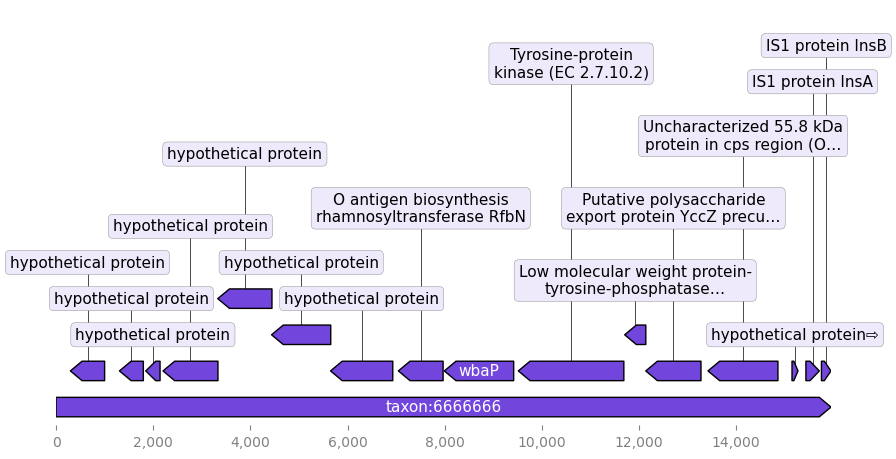

In [20]:
graphic_record = BiopythonTranslator().translate_record(mar_rec[39])
ax, _ = graphic_record.plot(figure_width=10, strand_in_label_threshold=7)

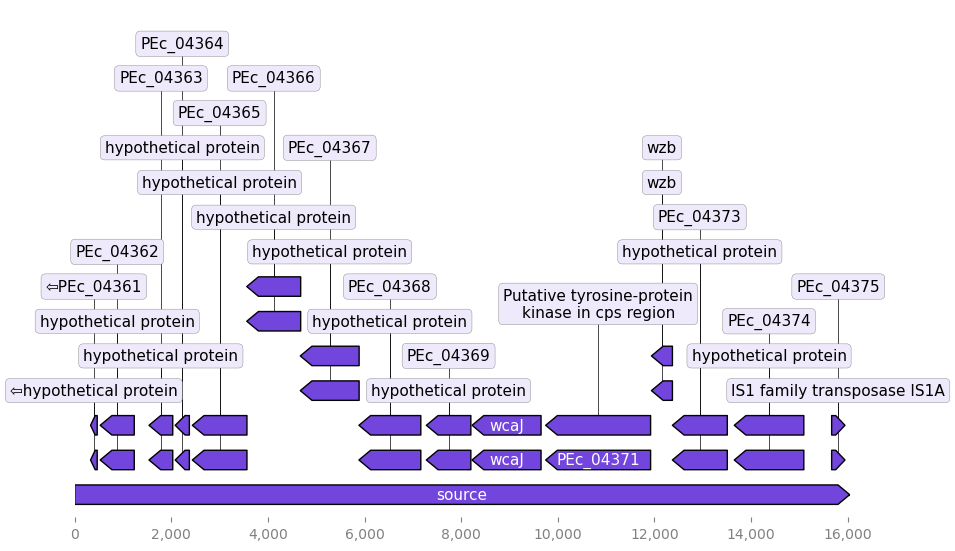

In [101]:
graphic_record = BiopythonTranslator().translate_record(records[35])
ax, _ = graphic_record.plot(figure_width=10, strand_in_label_threshold=7)

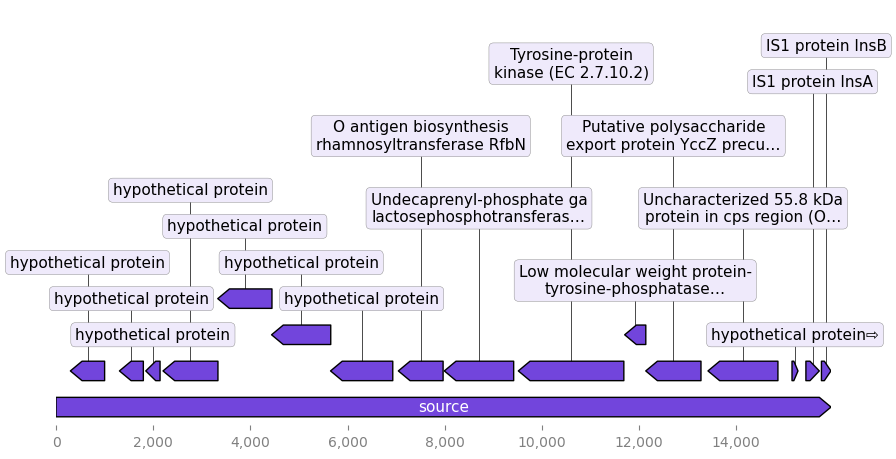

In [103]:
graphic_record = BiopythonTranslator().translate_record(mar_rec[39])
ax, _ = graphic_record.plot(figure_width=10, strand_in_label_threshold=7)

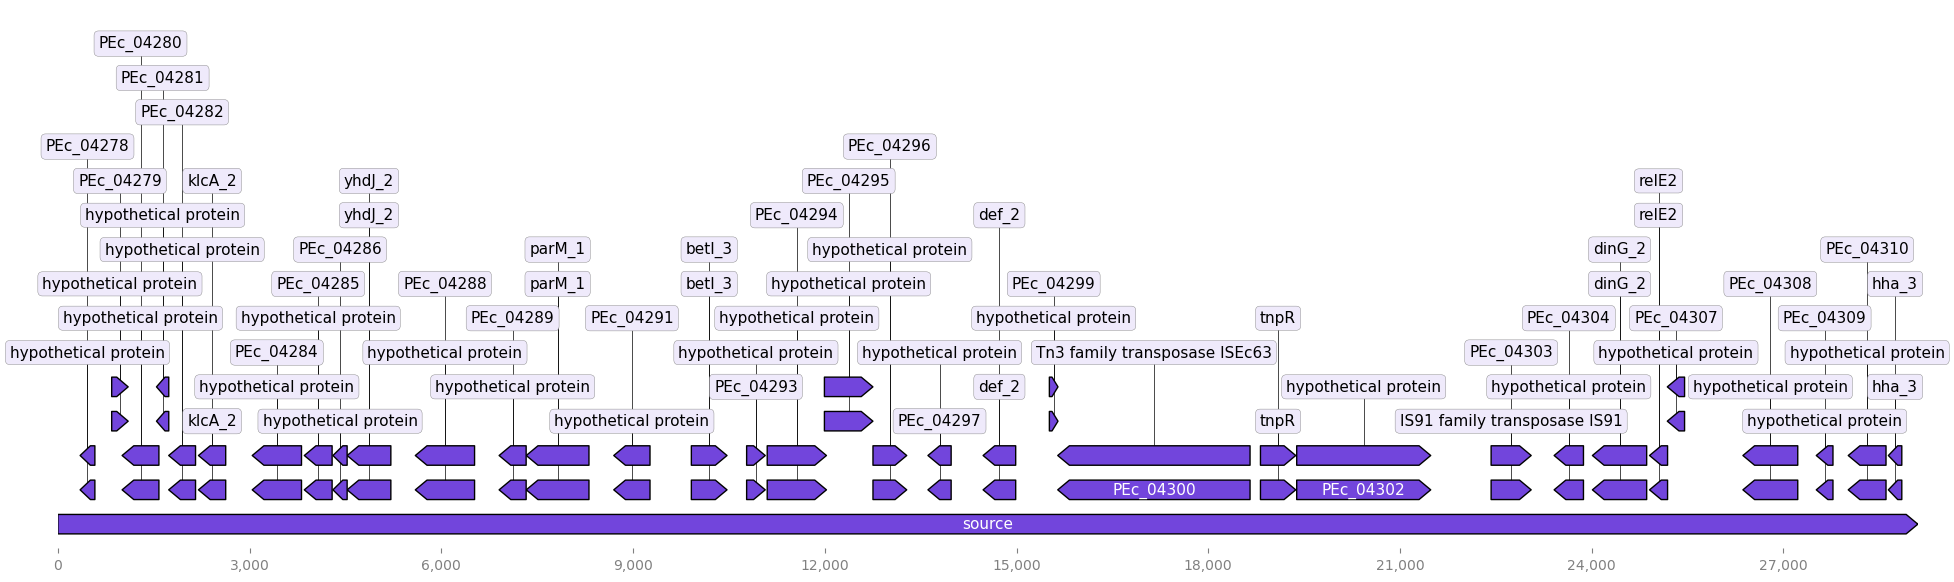

In [119]:
graphic_record = BiopythonTranslator().translate_record(records[32])
ax, _ = graphic_record.plot(figure_width=24, strand_in_label_threshold=7)

In [118]:
allvar[allvar['Original Scaffold Coordinate']=='NODE_1_length_575659_cov_33.563833:785-1083']

,index,Original Scaffold Coordinate,New Scaffold Coordinate,Original Sequence,New Sequence,Contig,Start,Mutation Type,Mutation Length,Overlapping Features,Sample ID
431,0,NODE_1_length_575659_cov_33.563833:785-1083,NODE_1_length_575659_cov_33.563833_pilon:785-1105,CTGTTTTGGCGGATGAGAGAAGATTTTCAGCCTGATACAGATTAAA...,NNNNNNNNNNGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTT...,NODE_1_length_575659_cov_33.563833,785-1083,SNP,1,,C3N_CO_LB7_S198
468,0,NODE_1_length_575659_cov_33.563833:785-1083,NODE_1_length_575659_cov_33.563833_pilon:785-1105,CTGTTTTGGCGGATGAGAGAAGATTTTCAGCCTGATACAGATTAAA...,NNNNNNNNNNGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTT...,NODE_1_length_575659_cov_33.563833,785-1083,SNP,1,,C3L_I_LB5_S202
961,0,NODE_1_length_575659_cov_33.563833:785-1083,NODE_1_length_575659_cov_33.563833_pilon:785-1105,CTGTTTTGGCGGATGAGAGAAGATTTTCAGCCTGATACAGATTAAA...,NNNNNNNNNNGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTT...,NODE_1_length_575659_cov_33.563833,785-1083,SNP,1,,3_5_S251
1046,0,NODE_1_length_575659_cov_33.563833:785-1083,NODE_1_length_575659_cov_33.563833_pilon:785-1105,CTGTTTTGGCGGATGAGAGAAGATTTTCAGCCTGATACAGATTAAA...,NNNNNNNNNNGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTT...,NODE_1_length_575659_cov_33.563833,785-1083,SNP,1,,C3N_I_LB1_S196
1293,0,NODE_1_length_575659_cov_33.563833:785-1083,NODE_1_length_575659_cov_33.563833_pilon:785-1105,CTGTTTTGGCGGATGAGAGAAGATTTTCAGCCTGATACAGATTAAA...,NNNNNNNNNNGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTT...,NODE_1_length_575659_cov_33.563833,785-1083,SNP,1,,C3L_CO_TSA3_S173
1612,0,NODE_1_length_575659_cov_33.563833:785-1083,NODE_1_length_575659_cov_33.563833_pilon:785-1105,CTGTTTTGGCGGATGAGAGAAGATTTTCAGCCTGATACAGATTAAA...,NNNNNNNNNNGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTT...,NODE_1_length_575659_cov_33.563833,785-1083,SNP,1,,C3N_C_TSA1-2_S216
1660,0,NODE_1_length_575659_cov_33.563833:785-1083,NODE_1_length_575659_cov_33.563833_pilon:785-1105,CTGTTTTGGCGGATGAGAGAAGATTTTCAGCCTGATACAGATTAAA...,NNNNNNNNNNGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTT...,NODE_1_length_575659_cov_33.563833,785-1083,SNP,1,,C4L_C_LB2_S224
2118,0,NODE_1_length_575659_cov_33.563833:785-1083,NODE_1_length_575659_cov_33.563833_pilon:785-1105,CTGTTTTGGCGGATGAGAGAAGATTTTCAGCCTGATACAGATTAAA...,NNNNNNNNNNGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTT...,NODE_1_length_575659_cov_33.563833,785-1083,SNP,1,,C4R_I_LB1_S226
2625,0,NODE_1_length_575659_cov_33.563833:785-1083,NODE_1_length_575659_cov_33.563833_pilon:785-1105,CTGTTTTGGCGGATGAGAGAAGATTTTCAGCCTGATACAGATTAAA...,NNNNNNNNNNGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTT...,NODE_1_length_575659_cov_33.563833,785-1083,SNP,1,,10_1_S118
